# 00 - MuJoCo Setup & Environment Test

## How to Run (Google Colab)

1. **Open in Colab**: Upload this notebook to [colab.research.google.com](https://colab.research.google.com)
2. **Run All Cells**: `Runtime` → `Run all` (or `Ctrl+F9`)
3. **Wait**: First cells install dependencies and create source files (~1-2 minutes)

The notebook is **self-contained** - it will:
- Install MuJoCo and dependencies
- Create all necessary source files automatically
- Test the soccer environment (physics simulation)

---

**Note**: 3D rendering may not work in all Colab environments (depends on GPU/GL libraries). This is fine - **all training, metrics logging, and plot generation work perfectly without rendering!**


In [1]:
# === Cell 1: Install dependencies and setup (Colab-compatible) ===
import os
import sys

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Set up headless rendering BEFORE importing mujoco
    os.environ['MUJOCO_GL'] = 'egl'

    # Install dependencies (including EGL support)
    print("Installing dependencies...")
    %pip install -q mujoco==3.1.6 gymnasium numpy matplotlib pandas

    # Create directory structure in Colab
    PROJECT_ROOT = "/content/soccer_rl"
    os.makedirs(f"{PROJECT_ROOT}/src", exist_ok=True)
    os.makedirs(f"{PROJECT_ROOT}/assets", exist_ok=True)
    os.makedirs(f"{PROJECT_ROOT}/notebooks", exist_ok=True)
    os.chdir(PROJECT_ROOT)
    print(f"Created project structure at {PROJECT_ROOT}")
    print(f"Set MUJOCO_GL=egl for headless rendering")
else:
    # Local setup (VS Code/Cursor)
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add to path
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Define paths
XML_PATH = os.path.join(PROJECT_ROOT, "assets", "soccer_min.xml")
LOG_PATH = os.path.join(PROJECT_ROOT, "notebooks", "MUJOCO_LOG.TXT")

print(f"\n{'='*50}")
print(f"Environment: {'Google Colab' if IN_COLAB else 'Local'}")
print(f"Project Root: {PROJECT_ROOT}")
print(f"{'='*50}")


Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 9.3 MB/s eta 0:00:00
Created project structure at /content/soccer_rl
Set MUJOCO_GL=egl for headless rendering

Environment: Google Colab
Project Root: /content/soccer_rl


In [2]:
# === Cell 2: Create source files (Colab only) ===
# This cell writes the source code files - only needed in Colab

if IN_COLAB:
    # ===== soccer_min.xml =====
    soccer_xml = '''<mujoco model="soccer_kick_demo">
  <compiler inertiafromgeom="true" angle="degree"/>
  <option timestep="0.002" gravity="0 0 -9.81"/>
  <worldbody>
    <geom name="ground" type="plane" size="12 12 0.1" rgba="0.25 0.32 0.25 1"
        friction="1.5 0.01 0.01" condim="3" solimp="0.95 0.99 0.001" solref="0.002 1"/>
    <body name="goal" pos="5 0 0.9">
      <geom name="left_post"  type="box" size="0.05 0.05 0.9" pos="0  1.2 0" rgba="1 1 1 1"/>
      <geom name="right_post" type="box" size="0.05 0.05 0.9" pos="0 -1.2 0" rgba="1 1 1 1"/>
      <geom name="crossbar"   type="box" size="0.05 1.2 0.05" pos="0 0 0.9" rgba="1 1 1 1"/>
      <geom name="net" type="box" size="0.02 1.2 0.9" pos="0 0 0"
            rgba="0.1 0.1 0.6 0.15" contype="0" conaffinity="0"/>
      <site name="target" pos="0 0 0" size="0.08" rgba="1 0 0 0.8"/>
    </body>
    <body name="ball" pos="-0.35 0 0.11">
        <joint name="ball_free" type="free" damping="0.002"/>
        <geom type="sphere" size="0.11" mass="0.20"
                rgba="0.85 0.85 0.85 1" friction="1.0 0.02 0.002" condim="3"/>
    </body>
    <body name="kicker" pos="-1.0 -0.25 0.11">
        <joint name="hinge" type="hinge" axis="0 1 0" range="-35 35"/>
        <geom name="foot" type="capsule" fromto="0 0 0 0.3 0 0" size="0.03" rgba="1 0 0 1"/>
        <site name="kick_site" pos="0.3 0 0" size="0.02" rgba="1 0 0 1"/>
    </body>
  </worldbody>
  <actuator>
    <motor name="kick_motor" joint="hinge" ctrlrange="-1 1" gear="300"/>
  </actuator>
</mujoco>'''

    with open(f"{PROJECT_ROOT}/assets/soccer_min.xml", "w") as f:
        f.write(soccer_xml)
    print("✓ Created assets/soccer_min.xml")

    # ===== src/soccer_env.py =====
    soccer_env_code = '''import mujoco
import numpy as np

class SoccerKickEnv:
    def __init__(self, xml_path, max_steps=3000, dt=0.002, seed=0):
        self.model = mujoco.MjModel.from_xml_path(xml_path)
        self.data  = mujoco.MjData(self.model)
        self.dt = float(dt)
        self.max_steps = int(max_steps)
        self.rng = np.random.default_rng(seed)
        self.seed_value = seed

        # Discrete action set: 5 angles x 5 speeds = 25 actions
        self.angles = np.deg2rad(np.array([-8, -4, 0, 4, 8], dtype=np.float32))
        self.speeds = np.array([8.0, 10.0, 12.0, 14.0, 16.0], dtype=np.float32)
        self.actions = [(th, v) for th in self.angles for v in self.speeds]

        self.site_target = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_SITE, "target")
        self.ball_body   = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, "ball")
        self.goal_body   = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, "goal")
        self.goal_x = float(self.model.body_pos[self.goal_body][0])

    def _ball_pos(self):
        return self.data.qpos[0:3].copy()

    def _ball_vel(self):
        return self.data.qvel[0:3].copy()

    def reset(self, target_random=True, seed=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        self.data = mujoco.MjData(self.model)
        mujoco.mj_forward(self.model, self.data)
        if target_random:
            x = self.goal_x + self.rng.uniform(-0.05, 0.05)
            y = self.rng.uniform(-0.9, 0.9)
            z = self.rng.uniform(0.7, 1.2)
            self.model.site_pos[self.site_target] = np.array([x, y, z], dtype=np.float64)
            mujoco.mj_forward(self.model, self.data)
        return self.model.site_pos[self.site_target].astype(np.float32).copy()

    def step(self, action_idx):
        nA = len(self.actions)
        idx = int(action_idx) % nA
        yaw, speed = self.actions[idx]
        yaw = float(yaw); speed = float(speed)
        yaw_deg = np.rad2deg(yaw)

        elev = np.deg2rad(20.0)
        # Use seeded RNG for reproducibility
        yaw  += np.deg2rad(self.rng.uniform(-1.0, 1.0))
        speed *= self.rng.uniform(0.95, 1.05)

        vx = float(speed * np.cos(elev) * np.cos(yaw))
        vy = float(speed * np.cos(elev) * np.sin(yaw))
        vz = float(speed * np.sin(elev))

        self.data.ctrl[:] = 0
        self.data.qvel[:] = 0
        mujoco.mj_forward(self.model, self.data)
        self.data.qvel[0:3] = np.array([vx, vy, vz], dtype=np.float64)

        crossed = False
        cross_pos = None
        for _ in range(self.max_steps):
            mujoco.mj_step(self.model, self.data)
            p = self._ball_pos()
            v = self._ball_vel()
            if (p[0] >= self.goal_x) and not crossed:
                crossed = True
                cross_pos = p.copy()
                break
            if np.linalg.norm(v) < 0.05 and p[2] < 0.12:
                break

        goal_y_half = 1.0
        goal_z_min  = 0.20
        goal_z_max  = 1.60

        if crossed and cross_pos is not None:
            y, z = float(cross_pos[1]), float(cross_pos[2])
            success = (-goal_y_half <= y <= goal_y_half) and (goal_z_min <= z <= goal_z_max)
            if success:
                reward = 5.0
                outcome = "goal"
            else:
                z_mid = 0.5 * (goal_z_min + goal_z_max)
                dy = abs(y) / goal_y_half
                dz = abs(z - z_mid) / (0.5 * (goal_z_max - goal_z_min))
                miss_penalty = 0.6 * dy + 0.4 * dz
                reward = 0.8 - 3.0 * miss_penalty
                outcome = "miss"
        else:
            end = self._ball_pos()
            dist_plane = abs(self.goal_x - float(end[0]))
            reward = -0.3 * dist_plane - 0.5
            success = False
            outcome = "miss"

        y_goal = float(cross_pos[1]) if cross_pos is not None else None
        z_goal = float(cross_pos[2]) if cross_pos is not None else None

        info = {
            "success": bool(success),
            "outcome": outcome,
            "cross_pos": cross_pos,
            "y_goal": y_goal,
            "z_goal": z_goal,
            "yaw_deg": yaw_deg,
            "speed": float(self.actions[idx][1])
        }
        return self._get_obs(), float(reward), True, info

    def _get_obs(self):
        ball = self._ball_pos()
        goal_center = np.array([self.goal_x, 0.0, 1.0], dtype=np.float32)
        return (goal_center - ball).astype(np.float32)
'''

    with open(f"{PROJECT_ROOT}/src/soccer_env.py", "w") as f:
        f.write(soccer_env_code)
    print("✓ Created src/soccer_env.py")

    # Create __init__.py
    with open(f"{PROJECT_ROOT}/src/__init__.py", "w") as f:
        f.write("# src module\n")
    print("✓ Created src/__init__.py")

    print("\n✓ All source files created successfully!")
else:
    print("Running locally - using existing source files")


✓ Created assets/soccer_min.xml
✓ Created src/soccer_env.py
✓ Created src/__init__.py

✓ All source files created successfully!


In [3]:
# === Cell 2: Test MuJoCo import and version ===
import mujoco
import numpy as np

print(f"MuJoCo version: {mujoco.__version__}")
print(f"NumPy version: {np.__version__}")

# Verify XML file exists
if os.path.exists(XML_PATH):
    print(f"✓ XML file found: {XML_PATH}")
else:
    print(f"✗ XML file NOT found: {XML_PATH}")


MuJoCo version: 3.1.6
NumPy version: 2.0.2
✓ XML file found: /content/soccer_rl/assets/soccer_min.xml


In [4]:
# === Cell 3: Load environment and test ===
from src.soccer_env import SoccerKickEnv

# Create environment with fixed seed for reproducibility
SEED = 42
env = SoccerKickEnv(XML_PATH, seed=SEED)

print(f"Environment created successfully!")
print(f"Goal X position: {env.goal_x}")
print(f"Number of discrete actions: {len(env.actions)}")
print(f"Action space (yaw_rad, speed): {env.actions[:3]}... (showing first 3)")


Environment created successfully!
Goal X position: 5.0
Number of discrete actions: 25
Action space (yaw_rad, speed): [(np.float32(-0.13962634), np.float32(8.0)), (np.float32(-0.13962634), np.float32(10.0)), (np.float32(-0.13962634), np.float32(12.0))]... (showing first 3)


In [5]:
# === Cell 4: Reset and take one action ===
obs = env.reset(target_random=True)
print(f"Initial observation (relative to target): {obs}")

# Take a kick action (action index 12 = middle yaw, middle speed)
action_idx = 12
yaw_rad, speed = env.actions[action_idx]
print(f"\nTaking action {action_idx}: yaw={np.rad2deg(yaw_rad):.1f}°, speed={speed:.1f} m/s")

obs_next, reward, done, info = env.step(action_idx)

print(f"\nResult:")
print(f"  Reward: {reward:.3f}")
print(f"  Success (goal): {info['success']}")
print(f"  Cross position: {info['cross_pos']}")


Initial observation (relative to target): [ 5.0273957  -0.11001881  1.1292989 ]

Taking action 12: yaw=0.0°, speed=12.0 m/s

Result:
  Reward: 5.000
  Success (goal): True
  Cross position: [5.00260551 0.03687706 0.84867784]


In [6]:
# === Cell 5: Log any MuJoCo warnings ===
import datetime

log_entry = f"""
--- MuJoCo Setup Test ---
Date: {datetime.datetime.now()}
MuJoCo version: {mujoco.__version__}
Environment loaded: OK
Action taken: OK
Result: reward={reward:.3f}, success={info['success']}
"""

with open(LOG_PATH, 'a') as f:
    f.write(log_entry)

print(f"Log appended to: {LOG_PATH}")


Log appended to: /content/soccer_rl/notebooks/MUJOCO_LOG.TXT


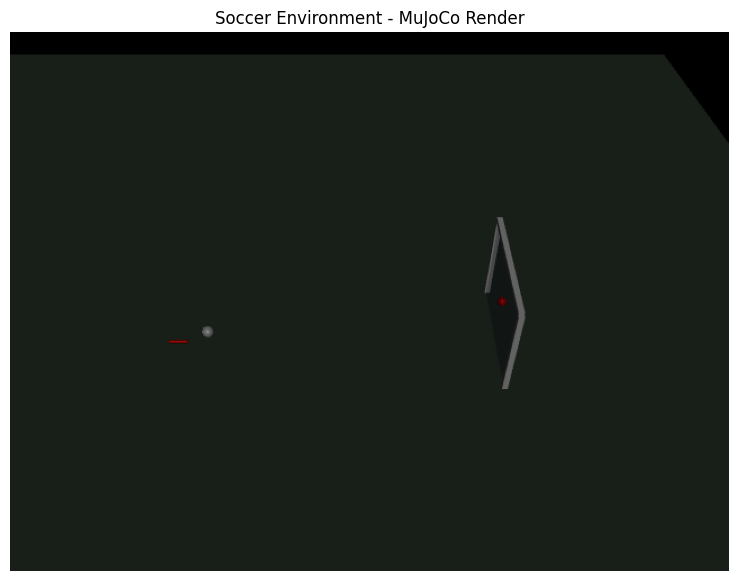

✓ Headless rendering works!


In [7]:
# === Cell 6: Render a frame (optional - may not work in all Colab environments) ===
import matplotlib.pyplot as plt

# Reset environment for a fresh view
env.reset(target_random=False)

try:
    # Render to an image array (headless with EGL)
    renderer = mujoco.Renderer(env.model, height=480, width=640)
    renderer.update_scene(env.data)
    frame = renderer.render()

    # Display the frame
    plt.figure(figsize=(10, 7))
    plt.imshow(frame)
    plt.axis('off')
    plt.title("Soccer Environment - MuJoCo Render")
    plt.show()
    print("✓ Headless rendering works!")
except Exception as e:
    print(f"⚠️ Rendering not available in this environment: {type(e).__name__}")
    print("This is OK - training and metrics will still work perfectly!")
    print("(Rendering requires GPU runtime or specific GL libraries)")


In [8]:
# === Cell 7: Summary ===
print("="*50)
print("MuJoCo Setup Test COMPLETE")
print("="*50)
print(f"✓ MuJoCo {mujoco.__version__} installed")
print(f"✓ Environment loads from assets/soccer_min.xml")
print(f"✓ Actions work ({len(env.actions)} discrete actions)")
print(f"✓ Reward/info returned correctly")
print(f"✓ Physics simulation works")
print(f"\nEnvironment: {'Google Colab' if IN_COLAB else 'Local'}")
print("\n→ Proceed to: 20_sarsa_kicker.ipynb for SARSA training")
print("\nNote: Rendering is optional. Training produces plots from logged data.")


MuJoCo Setup Test COMPLETE
✓ MuJoCo 3.1.6 installed
✓ Environment loads from assets/soccer_min.xml
✓ Actions work (25 discrete actions)
✓ Reward/info returned correctly
✓ Physics simulation works

Environment: Google Colab

→ Proceed to: 20_sarsa_kicker.ipynb for SARSA training

Note: Rendering is optional. Training produces plots from logged data.
